# Lab Assignment 5
## Andrew Marquardt

Question 1

In [129]:
import numpy as np
from tclab import TCLab, clock, Historian, Plotter

In [2]:
# I took the parameters I got from Lab 2 and recopied them here
CpH = 8.570225192333513 #Joules/degree C
CpS = 1.1198465579234749 #Joules/degree C
Ua = 0.03916910667788763 #Watts/degree C
Ub = 0.08256218948251515 #Watts/degree C
Uc = 0.03558351485126857 #Watts/degree C
alpha = 0.00016
P1 = 200
P2 = 100
Tamb = 21

In [3]:
print("CpH: " + str(CpH) + " Joules/degree C")
print("CpS: " + str(CpS) + " Joules/degree C")
print("Ua: " + str(Ua) + " Watts/degree C")
print("Ub: " + str(Ub) + " Watts/degree C")
print("Uc: " + str(Uc) + " Watts/degree C")

CpH: 8.570225192333513 Joules/degree C
CpS: 1.1198465579234749 Joules/degree C
Ua: 0.03916910667788763 Watts/degree C
Ub: 0.08256218948251515 Watts/degree C
Uc: 0.03558351485126857 Watts/degree C


Question 2

In [92]:
A = np.array([[-(Ua+Ub+Uc)/CpH,Ub/CpH,Uc/CpH,0],
              [Ub/CpS,-Ub/CpS,0,0],
              [Uc/CpH,0,-(Ua+Ub+Uc)/CpH,Ub/CpH],
              [0,0,Ub/CpS,-Ub/CpS]])
Bu = np.array([[alpha*P1/CpH,0],[0,0],[0,alpha*P2/CpH],[0,0]])
Bd = np.array([[Ua/CpH],[0],[Ua/CpH],[0]])
d = [Tamb]

In [5]:
eigenvalues, _ = np.linalg.eig(A)
print('Time constants from A:', -1.0/np.real(eigenvalues), 'seconds')

Time constants from A: [249.03750808  89.6329028   11.75396296  11.91684039] seconds


Question 3

In [109]:
L = np.array([[0.4,0],[0.2,0],[0,0.4],[0,0.2]])
C = np.array([[0,1,0,0],[0,0,0,1]])

Implement model on simulation; ensure that it runs correctly and tracks behavior correctly

In [110]:
# observer; modified to take multiple values
def tclab_observer(L):
    # initialize variables
    t_now = 0
    u_initial = np.array([[0],[0]])
    d_initial = d
    x_initial = np.array([[Tamb],[Tamb],[Tamb],[Tamb]])
    x_now = x_initial
    
    while True:
        # yield current state, get MV for next period
        t_next, Q1, Q2, T1_measured, T2_measured = yield x_now
        
        # model prediction
        u = np.array([[Q1],[Q2]])
        print("x_now:")
        print(x_now)
        x_predict = x_now + (t_next - t_now)*(np.dot(A, x_now) + np.dot(Bu, u) + np.dot(Bd, d))
        print("x_predict:")
        print(x_predict)
        # measurement correction
        y = np.array([[T1_measured],[T2_measured]])
        x_correct = x_predict - (t_next - t_now)*np.dot(L, np.dot(C, x_predict) - y)
        print("x_correct:")
        print(x_correct)
        # update time and state
        t_now = t_next
        x_now = x_correct

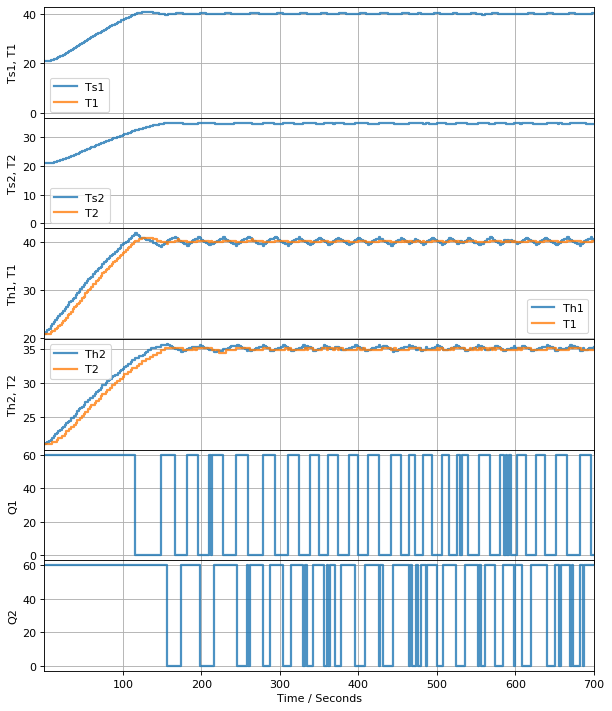

TCLab Model disconnected successfully.


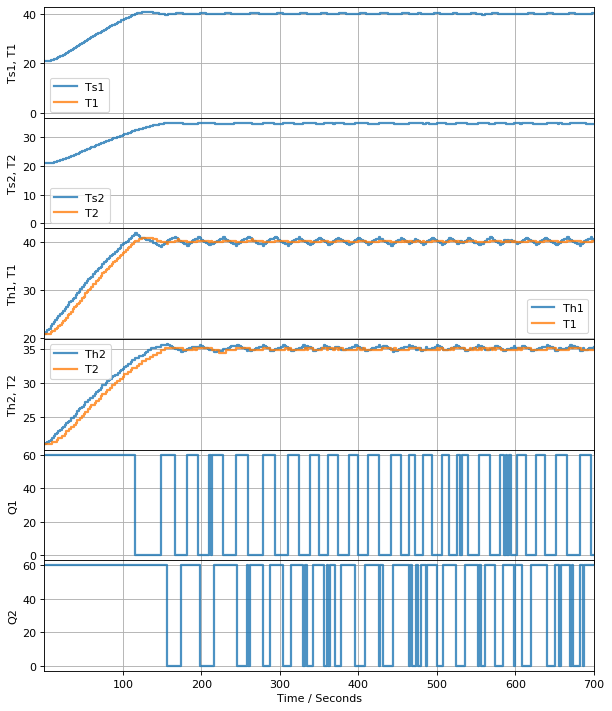

In [120]:
t_final = 700
t_step = 2

# Relay Controller
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

# simple set point values (constant through simulation)
def SP1(t):
    return 40
def SP2(t):
    return 35

# initialize controllers
controller1 = relay(0,60)
controller2 = relay(0,60)
U1 = next(controller1)
U2 = next(controller2)

# initialize observer
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# initialize heater values and observer model temperature values
u_initial = np.array([[0],[0]])
d_initial = d
x_initial = np.array([[Tamb],[Tamb],[Tamb],[Tamb]]) 

# execute the event loop
TCLab = setup(connected=False)
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)), ('SP2', lambda: SP2(t)), ('T1', lambda: lab.T1), 
                   ('T2', lambda: lab.T2), ('Q1', lab.Q1), ('Q2', lab.Q2), 
                   ('Th1', lambda: Th1), ('Ts1', lambda: Ts1), ('Th2', lambda: Th2), ('Ts2', lambda: Ts2)])
    p = Plotter(h, t_final, layout=[['Ts1','T1'], ['Ts2','T2'], ['Th1','T1'], ['Th2','T2'], 
                                    ['Q1'], ['Q2']])
    #p = Plotter(h,t_final)
    lab.P1 = P1
    lab.P2 = P2
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2])
        U1 = controller1.send([SP1(t), T1])
        U2 = controller2.send([SP2(t), T2])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

Because the behavior converged well and exhibited the expected behavior, I will consider this well-fit for the given L-matrix.

Question 4

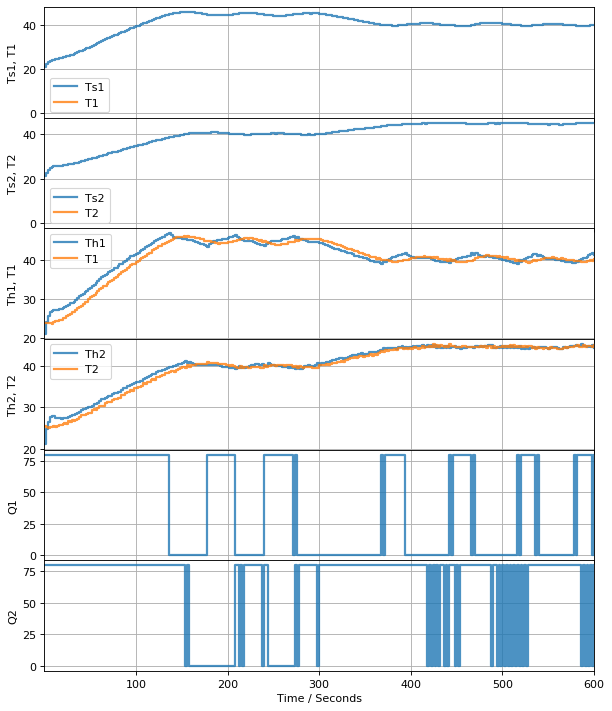

TCLab disconnected successfully.


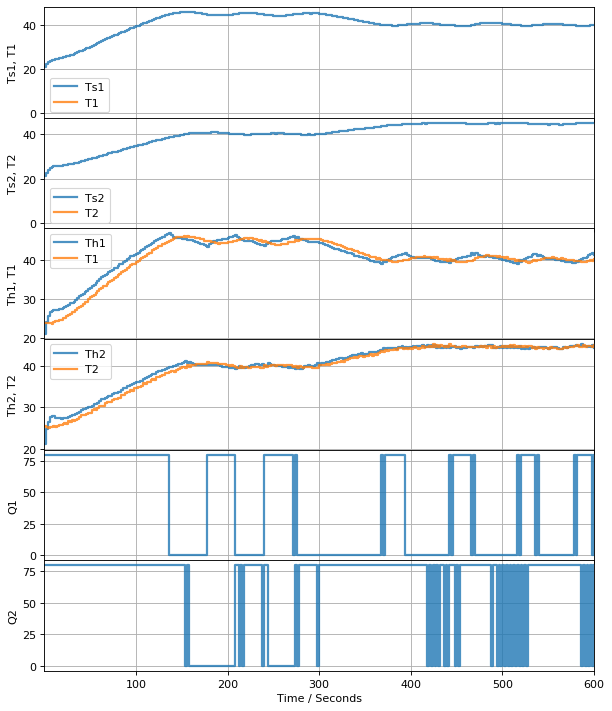

In [133]:
t_final = 600
t_step = 2

# Relay Controller
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

# simple set point values (constant through simulation)
def SP1(t):
    if t < 300:
        return 45
    else:
        return 40
def SP2(t):
    if t < 300:
        return 40
    else:
        return 45

# initialize controllers
controller1 = relay(0,80)
controller2 = relay(0,80)
U1 = next(controller1)
U2 = next(controller2)

# initialize observer
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# initialize heater values and observer model temperature values
u_initial = np.array([[0],[0]])
d_initial = d
x_initial = np.array([[Tamb],[Tamb],[Tamb],[Tamb]]) 

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)), ('SP2', lambda: SP2(t)), ('T1', lambda: lab.T1), 
                   ('T2', lambda: lab.T2), ('Q1', lab.Q1), ('Q2', lab.Q2), 
                   ('Th1', lambda: Th1), ('Ts1', lambda: Ts1), ('Th2', lambda: Th2), ('Ts2', lambda: Ts2)])
    p = Plotter(h, t_final, layout=[['Ts1','T1'], ['Ts2','T2'], ['Th1','T1'], ['Th2','T2'], 
                                    ['Q1'], ['Q2']])
    #p = Plotter(h,t_final)
    lab.P1 = P1
    lab.P2 = P2
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2])
        U1 = controller1.send([SP1(t), T1])
        U2 = controller2.send([SP2(t), T2])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)

In [132]:
with TCLab() as lab:
    print(lab.T1)
    print(lab.T2)

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware 3.0.0 Arduino Leonardo/Micro.
23.477
24.766
TCLab disconnected successfully.


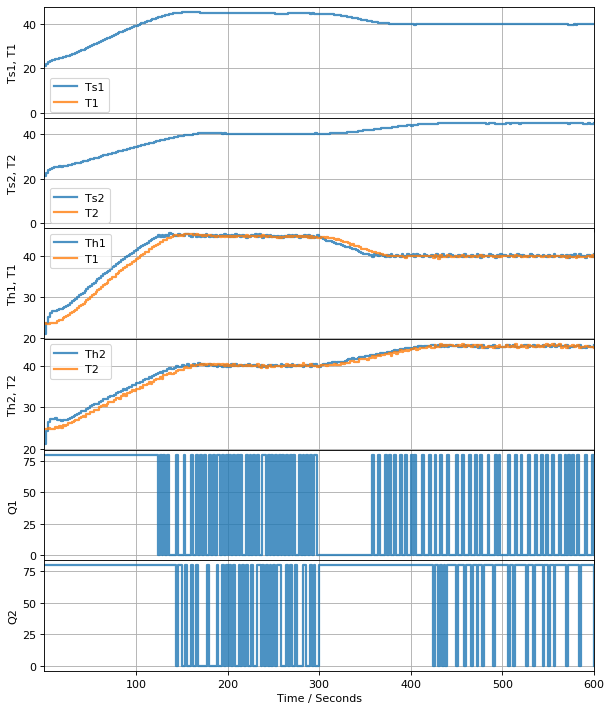

TCLab disconnected successfully.


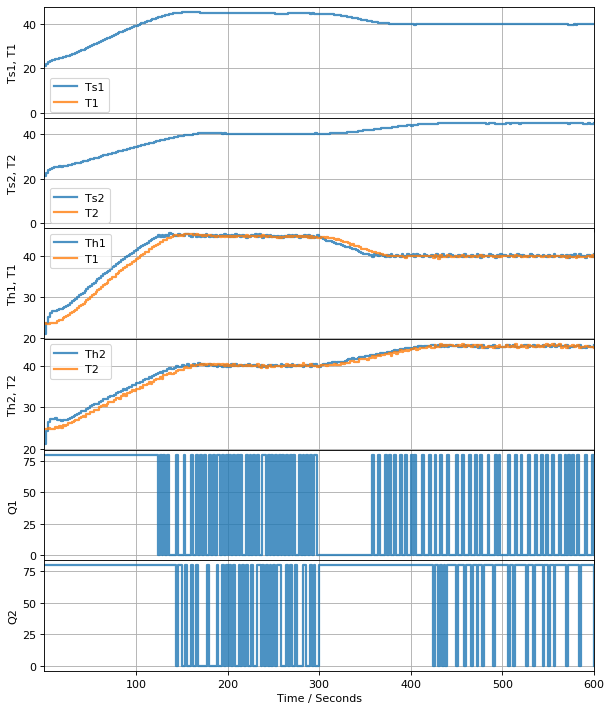

In [130]:
t_final = 600
t_step = 2

# Relay Controller
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

# simple set point values (constant through simulation)
def SP1(t):
    if t < 300:
        return 45
    else:
        return 40
def SP2(t):
    if t < 300:
        return 40
    else:
        return 45

# initialize controllers
controller1 = relay(0,80)
controller2 = relay(0,80)
U1 = next(controller1)
U2 = next(controller2)

# initialize observer
observer = tclab_observer(L)
Th1, Ts1, Th2, Ts2 = next(observer)

# initialize heater values and observer model temperature values
u_initial = np.array([[0],[0]])
d_initial = d
x_initial = np.array([[Tamb],[Tamb],[Tamb],[Tamb]]) 

# execute the event loop
with TCLab() as lab:
    h = Historian([('SP1', lambda: SP1(t)), ('SP2', lambda: SP2(t)), ('T1', lambda: lab.T1), 
                   ('T2', lambda: lab.T2), ('Q1', lab.Q1), ('Q2', lab.Q2), 
                   ('Th1', lambda: Th1), ('Ts1', lambda: Ts1), ('Th2', lambda: Th2), ('Ts2', lambda: Ts2)])
    p = Plotter(h, t_final, layout=[['Ts1','T1'], ['Ts2','T2'], ['Th1','T1'], ['Th2','T2'], 
                                    ['Q1'], ['Q2']])
    #p = Plotter(h,t_final)
    lab.P1 = P1
    lab.P2 = P2
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        T2 = lab.T2
        Th1, Ts1, Th2, Ts2 = observer.send([t, U1, U2, T1, T2])
        U1 = controller1.send([SP1(t), Th1])
        U2 = controller2.send([SP2(t), Th2])
        lab.Q1(U1)
        lab.Q2(U2)
        p.update(t)